In [3]:
# Target: Predict users rating on movies with collaborative effect and side information
# with users', movies' ID and movies' genres.
# With these ID like sparse features, and users' ratings, we can construct a regression problem.


# Firstly, load all the data required
from recom.datasets import load_ml_small_rating, load_movie_genres

# rating dataset
dataset = load_ml_small_rating(need_raw=True, time_ord=True, test_perc=0.1)
# load features
ratings = dataset['raw']    
ratings_train_dict = dataset['train_dict']
ratings_test_dict = dataset['test_dict']
n_user = dataset['n_user']
n_item = dataset['n_item']
user2ix = dataset['user2ix']
ix2user = dataset['ix2user']
item2ix = dataset['item2ix']
ix2item = dataset['ix2item']

del dataset

# genre info
genres = load_movie_genres('./recom/datasets/ml-small/movies.csv', sep=',')
genre_vec = {item2ix[item]:genres['g_vec'][item]
             for item in item2ix}
genre_dict = {item2ix[item]:[item for item in genres['g_base'][item].split('|') if item != '(no genres listed)']
              for item in item2ix}
genre2ix = genres['g2ix']
ix2genre = genres['ix2g']
n_genre = len(genres['g2ix'])

del genres

print(f'Users: {n_user}, Items: {n_item}. Sparsity: {round(1-len(ratings)/n_user/n_item, 4)}')
print(f'User reduced from {len(user2ix.keys())} to {len(ratings_train_dict.keys())}')
print(f'Total genres {len(genre2ix)}. Average genres {sum([sum(i[1]) for i in genre_vec.items()])/len(genre_vec)}.')

Users: 610, Items: 9724. Sparsity: 0.9831
User reduced from 610 to 609
Total genres 20. Average genres 2.2636774989716164.


In [4]:
def create_sparse_ratings(rat_dict, genre_dict, n_user, n_item, g2ix):
    import torch

    n_row = sum([len(i[-1]) for i in list(rat_dict.items())])
    n_col = n_user + n_item + len(g2ix)
    # dataset
    X = torch.zeros([n_row, n_col])
    y = torch.zeros([n_row, ])

    line = 0
    for user in rat_dict:
        for item in rat_dict[user]:
            # One-hot features
            X[line, user]=1
            X[line, n_user+item]=1
            for genre in genre_dict[item]:
                gix = g2ix[genre]
                X[line, n_user+n_item+gix]=1
            # Ratings
            y[line] = rat_dict[user][item]
            # move to the next line
            line+=1

    return X, y


def fm_data_loader(X, y, batch_size=128, shuffle=True):
    from torch.utils.data import DataLoader

    return DataLoader(list(zip(X, y)), batch_size=128, shuffle=True)
    



train_X, train_y = create_sparse_ratings(ratings_train_dict, genre_dict, n_user, n_item, genre2ix)
train_dl = fm_data_loader(train_X, train_y, batch_size=128, shuffle=True)
print(f'Training dataset shape: {train_X.shape}')

test_X, test_y = create_sparse_ratings(ratings_test_dict, genre_dict, n_user, n_item, genre2ix)
print(f'Testing dataset shape: {test_X.shape}')

Training dataset shape: torch.Size([73386, 10354])
Testing dataset shape: torch.Size([7843, 10354])


In [59]:
def fm_neg_sampler(rat_dict, genre_dict, g2ix, neg_size, neg_dict):
    import torch
    import random

    n_row = sum([len(i[-1]) for i in list(rat_dict.items())])
    n_col = n_user + n_item + len(g2ix)

    # dataset
    X = torch.zeros([n_row*neg_size, n_col])
    y = torch.zeros([n_row*neg_size, ])

    line = 0
    for user in rat_dict:
        for item in rat_dict[user]:
            # One-hot features
            X[line, user]=1
            rand_item = random.choice(neg_dict[user])
            X[line, n_user+rand_item]=1
            for genre in genre_dict[rand_item]:
                gix = g2ix[genre]
                X[line, n_user+n_item+gix]=1
            # Ratings
            y[line] = 0
            # move to the next line
            line+=1

    return X, y


# items = list(range(n_item))
# user_neg_dict = {
#     u:list(set(items)-set(ratings_train_dict[u].keys()))
#      for u in ratings_train_dict
# }

# Here my memory do not support such negative sampling, but it indeed can work
# neg_X, neg_y = fm_neg_sampler(ratings_train_dict, genre_dict, genre2ix, neg_size=1, neg_dict=user_neg_dict)
# neg_X.shape, neg_y.shape

In [6]:
import torch.nn as nn
from torch import Tensor, LongTensor


class LinearReg(nn.Module):
    """ Linear Regression Baseline """
    def __init__(self, n_feat) -> None:
        super(LinearReg, self).__init__()
        self.Linear = nn.Linear(n_feat, 1)
        nn.init.normal_(self.Linear.weight, mean=0, std=0.1)

    def forward(self, x):
        return self.Linear(x).squeeze()


class FM(nn.Module):
    """ Factorization Machine Regressor """
    def __init__(self, n_feat, k_dim) -> None:
        super(FM, self).__init__()
        self.Linear = nn.Linear(n_feat, 1)
        self.embedding_feat = nn.Embedding(n_feat, k_dim)
        # init param
        nn.init.normal_(self.Linear.weight, mean=0, std=0.1)
        nn.init.normal_(self.embedding_feat.weight, mean=0, std=0.1)

    def forward(self, x):
        product = x @ self.embedding_feat.weight
        sq_of_sum = (product.sum(1))**2
        sum_of_sq = (product**2).sum(1)

        return self.Linear(x).squeeze() + 0.5*(sq_of_sum-sum_of_sq)


In [8]:
import time
from torch import autograd, LongTensor, device
from torch import optim
import numpy as np


def SE(input, target):
    return (target-input)**2


def train_model(model, opt
                , train_X, train_y, test_X=None, test_y=None
                , use_cuda=False, n_epochs=16, report_interval=4):
    if use_cuda:
        compute_device = device('cuda')
        model.cuda()
        train_X, train_y = train_X.to(compute_device), train_y.to(compute_device)
        if test_X is not None:
            test_X, test_y = test_X.to(compute_device), test_y.to(compute_device)
    else:
        compute_device = device('cpu')

    train_loss_by_ep = []
    test_rmse_by_ep = []

    t0 = time.time()
    for epoch in range(n_epochs):
        train_data = fm_data_loader(train_X, train_y, batch_size=128, shuffle=True)

        ep_loss = []
        for i, batch in enumerate(train_data):
            Xs, score = batch

            model.zero_grad()

            Xs = autograd.Variable(Xs).to(compute_device)

            preds = model(Xs)
            loss = SE(input=preds, target=score)
            loss.mean().backward()
            opt.step()
            ep_loss.extend(loss.data.to(compute_device).tolist())

        train_loss_by_ep.append(np.sqrt(np.mean(ep_loss)))
        
        # test
        preds = model(test_X)
        test_rmse = SE(preds, test_y).mean().sqrt()
        test_rmse_by_ep.append(test_rmse.data.to(compute_device).tolist())

        if report_interval > 0 \
                and ((epoch+1) % report_interval == 0):
            
            t1=time.time()
            print(f'Epoch: {epoch+1}, Time: {round(t1-t0,2)},  /Average train loss {round(sum(train_loss_by_ep[-report_interval:])/report_interval, 5)}')
            print(f'\t\t\t/Average test loss {round(sum(test_rmse_by_ep[-report_interval:])/report_interval, 5)}')
            t0=time.time()

    model = model.to('cpu') # send to cpu anyway
    
    return model, train_loss_by_ep, test_rmse_by_ep


# Init Model
K_DIM = 12
N_EPOCHS = 16
REPORT_INTERVAL = 4
USE_CUDA = False

n_feat = n_user + n_item + n_genre

# Ridge Regression
lm = LinearReg(n_feat=n_feat)
lm_opt = optim.Adam(lm.parameters(), lr=0.01, weight_decay=1e-7)
lm, lm_train_loss, lm_test_rmse = train_model(lm, lm_opt
                                              , train_X, train_y, test_X=test_X, test_y=test_y
                                              , use_cuda=False, n_epochs=N_EPOCHS, report_interval=REPORT_INTERVAL)

# Factorization Machine Regression
# fm = FM(n_feat=n_feat, k_dim=K_DIM)
# fm_opt = optim.Adam(fm.parameters(), lr=0.001, weight_decay=1e-5)
# fm, fm_train_loss, fm_test_rmse = train_model(fm, fm_opt
#                                               , train_X, train_y, test_X=test_X, test_y=test_y
#                                               , use_cuda=False, n_epochs=N_EPOCHS, report_interval=REPORT_INTERVAL)

# D

Epoch: 4, Time: 77.82,  /Average train loss 0.76106
			/Average test loss 0.66231
Epoch: 8, Time: 13.08,  /Average train loss 0.56807
			/Average test loss 0.63581
Epoch: 12, Time: 14.69,  /Average train loss 0.56751
			/Average test loss 0.63762
Epoch: 16, Time: 14.17,  /Average train loss 0.56775
			/Average test loss 0.64028


In [26]:
# Factorization Machine Regression
fm = FM(n_feat=n_feat, k_dim=4)
fm_opt = optim.Adam(fm.parameters(), lr=0.004, weight_decay=1e-5)
fm, fm_train_loss, fm_test_rmse = train_model(fm, fm_opt
                                              , train_X, train_y, test_X=test_X, test_y=test_y
                                              , use_cuda=False, n_epochs=N_EPOCHS, report_interval=REPORT_INTERVAL)


Epoch: 4, Time: 77.84,  /Average train loss 0.84737
			/Average test loss 0.73789
Epoch: 8, Time: 25.29,  /Average train loss 0.57787
			/Average test loss 0.67515
Epoch: 12, Time: 21.06,  /Average train loss 0.55985
			/Average test loss 0.65327
Epoch: 16, Time: 20.03,  /Average train loss 0.53916
			/Average test loss 0.64258


In [28]:
lm_train_loss[-5:], fm_train_loss[-5:]

([0.567760560882912,
  0.5680888370650966,
  0.5676327684371596,
  0.5676427542632047,
  0.5676372170987247],
 [0.5524458540773262,
  0.547445402621382,
  0.5421553850955634,
  0.5361405382183604,
  0.5309051617574687])

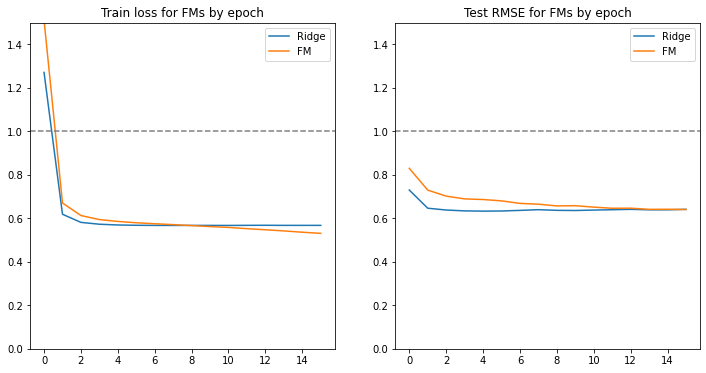

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Cut your window in 1 row and 2 columns, and start a plot in the first part
plt.subplot(121)
plt.plot(list(range(N_EPOCHS)), lm_train_loss)
plt.plot(list(range(N_EPOCHS)), fm_train_loss)
plt.axhline(y=1, color='grey', linestyle='--')
plt.legend(['Ridge', 'FM'])
plt.title("Train loss for FMs by epoch")
plt.ylim([0,1.5])

# And now add something in the second part:
plt.subplot(122)
plt.plot(list(range(N_EPOCHS)), lm_test_rmse)
plt.plot(list(range(N_EPOCHS)), fm_test_rmse)
plt.axhline(y=1, color='grey', linestyle='--')
plt.legend(['Ridge', 'FM'])
plt.title("Test RMSE for FMs by epoch")
plt.ylim([0,1.5])

# Show the graph
plt.show()